<a href="https://colab.research.google.com/github/akirakudo901/RaymondLab/blob/main/Visualize_Feature_Distribution_Per_B_SOID_Bout_Cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Visualize feature distribution per B-SOID bout cluster**
____
**!! TO READ !!**

This notebook is designed to be ran on the **conda environment bsoid_v2** on the **NINC B-SOID computer**!

To use this via Google Colab with a local runtime:

- On the **NINC B-SOID computer**, open the **Anaconda Prompt**.
- Type ```conda activate bsoid_v2```.
- Type ```jupyter notebook```.
 - On the first try, you might want to type:
   ```jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0```
- Once Jupyter Notebook starts, find in **Anaconda Prompt** a line of the form: ```http://localhost:8888/?token=abc```
- In **Google Colab**, to the **top right**, click on **Connect** > **Connect to a local runtime**.
- In the prompt, **enter the URL** obtained **two steps before**.



## **Set Up**
---

In [ ]:
#@title Importing Packages
# FOR B-SOID CODE TO FUNCTION:
import joblib

# FOR MY OWN FUNCTIONS:
import os
from typing import List

import numpy as np
import pandas as pd

##**Function definitions**
---

### **Import functions from the B-SOID repo**


In [ ]:
#@title bsoid_extract
# under bsoid_app/bsoid_utilities/bsoid_classification bsoid_extract

import math

def bsoid_extract(data, fps):
    """
    Extracts features based on (x,y) positions
    :param data: list, csv data
    :param fps: scalar, input for camera frame-rate
    :return f_10fps: 2D array, extracted features
    """
    win_len = np.int32(np.round(0.05 / (1 / fps)) * 2 - 1)
    feats = []
    for m in range(len(data)):
        dataRange = len(data[m])
        dxy_r = []
        dis_r = []
        for r in range(dataRange):
            if r < dataRange - 1:
                dis = []
                for c in range(0, data[m].shape[1], 2):
                    dis.append(np.linalg.norm(data[m][r + 1, c:c + 2] - data[m][r, c:c + 2]))
                dis_r.append(dis)
            dxy = []
            for i, j in itertools.combinations(range(0, data[m].shape[1], 2), 2):
                dxy.append(data[m][r, i:i + 2] - data[m][r, j:j + 2])
            dxy_r.append(dxy)
        dis_r = np.array(dis_r)
        dxy_r = np.array(dxy_r)
        dis_smth = []
        dxy_eu = np.zeros([dataRange, dxy_r.shape[1]])
        ang = np.zeros([dataRange - 1, dxy_r.shape[1]])
        dxy_smth = []
        ang_smth = []
        for l in range(dis_r.shape[1]):
            dis_smth.append(boxcar_center(dis_r[:, l], win_len))
        for k in range(dxy_r.shape[1]):
            for kk in range(dataRange):
                dxy_eu[kk, k] = np.linalg.norm(dxy_r[kk, k, :])
                if kk < dataRange - 1:
                    b_3d = np.hstack([dxy_r[kk + 1, k, :], 0])
                    a_3d = np.hstack([dxy_r[kk, k, :], 0])
                    c = np.cross(b_3d, a_3d)
                    ang[kk, k] = np.dot(np.dot(np.sign(c[2]), 180) / np.pi,
                                        math.atan2(np.linalg.norm(c),
                                                   np.dot(dxy_r[kk, k, :], dxy_r[kk + 1, k, :])))
            dxy_smth.append(boxcar_center(dxy_eu[:, k], win_len))
            ang_smth.append(boxcar_center(ang[:, k], win_len))
        dis_smth = np.array(dis_smth)
        dxy_smth = np.array(dxy_smth)
        ang_smth = np.array(ang_smth)
        feats.append(np.vstack((dxy_smth[:, 1:], ang_smth, dis_smth)))
    f_10fps = []
    for n in range(0, len(feats)):
        feats1 = np.zeros(len(data[n]))
        for s in range(math.floor(fps / 10)):
            for k in range(round(fps / 10) + s, len(feats[n][0]), round(fps / 10)):
                    if k > round(fps / 10) + s:
                        feats1 = np.concatenate((feats1.reshape(feats1.shape[0], feats1.shape[1]),
                                                 np.hstack((np.mean((feats[n][0:dxy_smth.shape[0],
                                                                     range(k - round(fps / 10), k)]), axis=1),
                                                            np.sum((feats[n][dxy_smth.shape[0]:feats[n].shape[0],
                                                                    range(k - round(fps / 10), k)]),
                                                                   axis=1))).reshape(len(feats[0]), 1)), axis=1)
                    else:
                        feats1 = np.hstack((np.mean((feats[n][0:dxy_smth.shape[0], range(k - round(fps / 10), k)]),
                                                    axis=1),
                                            np.sum((feats[n][dxy_smth.shape[0]:feats[n].shape[0],
                                                    range(k - round(fps / 10), k)]), axis=1))).reshape(len(feats[0]), 1)
            f_10fps.append(feats1)
    return f_10fps

In [ ]:
#@title bsoid_predict
# under bsoid_app/bsoid_utilities/bsoid_classification bsoid_predict
def bsoid_predict(feats, clf):
    """
    :param feats: list, multiple feats (original feature space)
    :param clf: Obj, MLP classifier
    :return nonfs_labels: list, label/100ms
    """
    labels_fslow = []
    for i in range(0, len(feats)):
        labels = clf.predict(feats[i].T)
        labels_fslow.append(labels)
    return labels_fslow

In [ ]:
#@title adp_filt - can change between brute thresholding and automatic
# under bsoid_app/bsoid_utilities/likelihoodprocessing adp_filt

# Original code finds an adaptive threshold to use for filtering outlier
# values of position from the csv file. We can also use a brute threshold
# which is automatically set to a value (say 0.8) - basically detecting
# any entry in DLC output that has probability <0.8, and replace it with
# the latest most-probable prediction
from tqdm import tqdm
def adp_filt(currdf: object, pose):
    lIndex = []
    xIndex = []
    yIndex = []
    currdf = np.array(currdf[1:])
    for header in pose:
        if currdf[0][header + 1] == "likelihood":
            lIndex.append(header)
        elif currdf[0][header + 1] == "x":
            xIndex.append(header)
        elif currdf[0][header + 1] == "y":
            yIndex.append(header)
    curr_df1 = currdf[:, 1:]
    datax = curr_df1[1:, np.array(xIndex)]
    datay = curr_df1[1:, np.array(yIndex)]
    data_lh = curr_df1[1:, np.array(lIndex)]
    currdf_filt = np.zeros((datax.shape[0], (datax.shape[1]) * 2))
    perc_rect = []
    for i in range(data_lh.shape[1]):
        perc_rect.append(0)
    for x in tqdm(range(data_lh.shape[1])):
        a, b = np.histogram(data_lh[1:, x].astype(np.float32))
        rise_a = np.where(np.diff(a) >= 0)
        if rise_a[0][0] > 1:
            llh = b[rise_a[0][0]]
        else:
            llh = b[rise_a[0][1]]
        ##################
        # ADDED BY AKIRA
        if BRUTE_THRESHOLDING:
          llh = 0.8
        ##################
        data_lh_float = data_lh[:, x].astype(np.float32)
        perc_rect[x] = np.sum(data_lh_float < llh) / data_lh.shape[0]
        currdf_filt[0, (2 * x):(2 * x + 2)] = np.hstack([datax[0, x], datay[0, x]])
        for i in range(1, data_lh.shape[0]):
            if data_lh_float[i] < llh:
                currdf_filt[i, (2 * x):(2 * x + 2)] = currdf_filt[i - 1, (2 * x):(2 * x + 2)]
            else:
                currdf_filt[i, (2 * x):(2 * x + 2)] = np.hstack([datax[i, x], datay[i, x]])
    currdf_filt = np.array(currdf_filt)
    currdf_filt = currdf_filt.astype(np.float32)
    return currdf_filt, perc_rect

In [ ]:
#@title boxcar_center
# under bsoid_app/bsoid_utilities/likelihoodprocessing boxcar_center
def boxcar_center(a, n):
    a1 = pd.Series(a)
    moving_avg = np.array(a1.rolling(window=n, min_periods=1, center=True).mean())

    return moving_avg

### **Define my own functions**

In [ ]:
#@title extract_label_and_feature_from_csv
FEATURE_SAVING_FOLDERS = "./B-SOID_features/results/figures"
FEATURE_FILE_SUFFIX = "_features.npy"
LABEL_FILE_SUFFIX = "_labels.npy"

# Extract both labels and features from a csv file

def extract_label_and_feature_from_csv(filepath : str, pose : List[int],
                                       clf_path : str, fps : int=40,
                                       save_result=True, save_path=FEATURE_SAVING_FOLDERS,
                                       recompute=False,  load_path=FEATURE_SAVING_FOLDERS):
  """
  Given the path to a csv name to be analyzed, extracts and computes both the
  labels and features from it. Does check if previous computations have been
  made for both the labels and features, and if it finds both, will skip
  computation (unless instructed to recompute).
  :param str filepath: Path to csv file to be analyzed.
  :param List[int] pose: A list of indices relative to the csv that specifies
  which body part to use for computation. e.g. [0,1,2,6,7,8] will use those
  columns with those indices for computation.
  :param str clf_path: The path to the classifier-stored sav file, often
  called 'PREFIX_randomforest.sav'.
  :param int fps: Framerate for video. Defaults to 40, given Ellen's project.
  :param bool save_result: Whether to save the computed features under
  save_path. Defaults to true.
  "param str save_path: The folder to which we save computed features.
  Defaults to FEATURE_SAVING_FOLDERS.
  :param bool recompute: Whether to recompute features saved under load_path.
  :param str load_path: The path from which we attempt to load precomputed
  features. Defaults to FEATURE_SAVING_FOLDERS.
  """

  filename = os.path.basename(filepath)
  clfname = os.path.basename(clf_path).replace('_randomforest.sav', '')
  feature_save_filename = clfname + "_" + filename + FEATURE_FILE_SUFFIX
  label_save_filename   = clfname + "_" + filename + LABEL_FILE_SUFFIX

  if not recompute:
    # attempt fetch
    feature = fetch_precomputed_from_npy(os.path.join(load_path, feature_save_filename))
    label   = fetch_precomputed_from_npy(os.path.join(load_path,   label_save_filename))
    # if it doesn't work, recompute
    if feature is None or label is None: recompute = True

  if recompute:
    # read data from csv and filter data
    file_j_df = pd.read_csv(filepath, low_memory=False)
    file_j_processed, _ = adp_filt(file_j_df, pose)
    # code assumes multiple data processed at once, though I will only process one
    final_labels = []
    labels_fs = []
    # extraction & prediction, while also computing the merged feature at once
    feature, feats_new = compute_merged_features_from_csv_data(file_j_processed, fps)
    clf = load_classifier(clf_path)
    labels = bsoid_predict(feats_new, clf)
    # padding of labels
    # invert the content of labels
    for m in range(0, len(labels)):
        labels[m] = labels[m][::-1]
    # create all -1 padding with second size being length of longest label list
    labels_pad = -1 * np.ones([len(labels), len(max(labels, key=lambda x: len(x)))])
    # populate a frame-shifted stack of predictions that total to the whole video
    for n, l in enumerate(labels):
        labels_pad[n][0:len(l)] = l
        labels_pad[n] = labels_pad[n][::-1]
        if n > 0:
            labels_pad[n][0:n] = labels_pad[n - 1][0:n]
    labels_fs.append(labels_pad.astype(int))
    # Frameshift arrangement of predicted labels
    for l_fs in labels_fs:
        labels_fs2 = []
        for l in range(math.floor(fps / 10)):
            labels_fs2.append(l_fs[l])
        final_labels.append(np.array(labels_fs2).flatten('F'))
    label = final_labels[0]

    if save_result:
      print(f"Saving results to: {save_path}")
      np.save(os.path.join(save_path, feature_save_filename), feature)
      np.save(os.path.join(save_path,   label_save_filename),   label)

  return label, feature


# helper to load a classifier from a sav file
def load_classifier(path):
    with open(path, 'rb') as fr:
        [_, _, _, clf, _, _] = joblib.load(fr)
    return clf

# load previous file that holds computed values in the result folder
# path : A path to the file that holds pre-computed values.
# Returns: The values, or None if the file of interest did not exist.
def fetch_precomputed_from_npy(path):
    feature = None
    if os.path.exists(path):
        print(f"Fetching precomputed {path}!")
        feature = np.load(path, allow_pickle=True)
        print(f"Success!")
    return feature

In [ ]:
#@title compute_merged_features_from_csv_data
def compute_merged_features_from_csv_data(data : np.ndarray, fps : int):
  """
  Takes a single data np.ndarray and extracts & computes a merged feature set
  from it.
  :param np.ndarray data: The data numpy array from which we extract the
  features.
  :param int fps: Fps for the video we are dealing with.
  """
  feature = None
  # compute features from data - features is n lists of 10fps binned features
  # e.g. with a 40 fps video, we get 4 lists of 10 fps binned feature calculated
  #      something like [0,4], [1,5], [2,6] and [3,7] created from [0,1,2,3,4,5,6,7]
  #      where each number is the starting frame of a 10 fps bin
  premerged_feature = bsoid_extract([data], fps)
  # so we want to interleave them to get the final feature time series
  feature = np.empty((premerged_feature[0].shape[0], # each row is a feature
                            sum(feat.shape[1] for feat in premerged_feature)),  # get total length of all 10 fps data
                            dtype=premerged_feature[0].dtype)
  stride = len(premerged_feature) # the same feature vector is entered with a stride of how many features there are
  # e.g. merging [0,3], [1,4] and [2,5] into [0,1,2,3,4,5] is done with a stride of 3
  for i, feat in enumerate(premerged_feature):
      feature[:, i::stride] = feat
  return feature, premerged_feature

In [ ]:
#@title extract_pregenerated_labels_and_compute_features

# Author: Akira Kudo

"""
Extracts pregenerated label predictions, stored as 'bsoid_predictions.sav' files.
Simultaneously, extract pregenerated frameshifted data and uses it to compute features.
"""

def extract_pregenerated_labels_and_compute_features(predictionsPath, filename,
                              clf_sav_path : str, fps=40,
                              save_result=True, save_path=FEATURE_SAVING_FOLDERS,
                              recompute=False,  load_path=FEATURE_SAVING_FOLDERS):
    """
    Given a specific csv name that was analyzed, extracts a numpy.ndarray of
    frame-shifted labels stored within a 'predictions.sav' file at time of
    previous analysis. Simultaneously, extracts frameshifted data and uses it to
    compute frameshifted corresponding features.
    :param str filename: Name of csv that was analyzed in order to extract the
    labels of interest.
    :param str clf_sav_path: The path to the classifier-stored sav file, often
    called 'PREFIX_randomforest.sav'. Used to name storing files consistently.
    :param int fps: Framerate for video. Defaults to 40, given Ellen's project.
    :param bool save_result: Whether to save the computed features under
    save_path. Defaults to true.
    "param str save_path: The folder to which we save computed features.
    Defaults to FEATURE_SAVING_FOLDERS.
    :param bool recompute: Whether to recompute features saved under load_path.
    :param str load_path: The path from which we attempt to load precomputed
    features. Defaults to FEATURE_SAVING_FOLDERS.
    """

    # this is meant to be used as reference name
    # as of right now, it should hopefully match that of extract_label_and_feature_from_csv
    clfname = os.path.basename(clf_sav_path).replace('_randomforest.sav', '')
    feature_save_filename = clfname + "_" + filename + FEATURE_FILE_SUFFIX
    label_save_filename   = clfname + "_" + filename + LABEL_FILE_SUFFIX

    label = None; feature = None
    # As found under bsoid_app.predict:
    # listOfFolderPassed, listOfFolderForEachFileName, fileNames, positionData, labels = joblib.load(predictionsPath)
    _, _, fileNames, data, labels = joblib.load(predictionsPath)
    fileNames = [os.path.basename(fn) for fn in fileNames]
    # search filename as contained within fileNames
    idx_of_interest = None
    for idx, flnm in enumerate(fileNames):
      if filename in flnm: idx_of_interest = idx; break

    # if we can't find a matching result, return default values (Nones)
    if idx_of_interest is None:
        print("No matching filename found in extract_pregenerated_labels_and_compute_features.")
        return label, feature

    # otherwise, get label first
    label = labels[idx_of_interest]
    # if recompute is set to false, look for fetching
    if not recompute:
        feature = fetch_precomputed_from_npy(os.path.join(load_path, feature_save_filename))

        if feature is None:
             print(f"Failed fetching a precompute set of feature from {load_path}; computing.")
             recompute = True

    if recompute:
        # then also get frameshifted data
        data_of_interest = data[idx_of_interest]
        # compute the feature from it
        feature, _ = compute_merged_features_from_csv_data(data_of_interest, fps=fps)

        if save_result:
            print(f"Saving results to: {save_path}")
            np.save(os.path.join(save_path, feature_save_filename), feature)
            np.save(os.path.join(save_path,   label_save_filename),   label)

    return label, feature

In [ ]:
#@title Defining body parts for rendering features

from enum import Enum
import itertools

# define an enumeration for body parts
Bodypart = Enum('Bodypart', ["SNOUT", "RIGHTFOREPAW", "LEFTFOREPAW",
                             "RIGHTHINDPAW", "LEFTHINDPAW",
                             "TAILBASE", "BELLY"])

# some useful functions to internally align names
def relative_placement_name(bp1 : Bodypart, bp2 : Bodypart):
  # swap values to ensure a strict ordering
  if bp1.value > bp2.value: bp1, bp2 = bp2, bp1
  return "Relative {} to {} placement".format(bp1.name, bp2.name)

def relative_angle_name(bp1 : Bodypart, bp2 : Bodypart):
  # swap values to ensure a strict ordering
  if bp1.value > bp2.value: bp1, bp2 = bp2, bp1
  return "Relative angle from {} to {}".format(bp1.name, bp2.name)

def displacement_name(bp : Bodypart):
  return "Displacement of {}".format(bp.name)

# Given features are extracted in an internal order as read from the csv that
# holds the original data, this generates a good guess on which feature index
# in the feature vector created by the above function of
# extract_pregenerated_labels_and_compute_features
# correspond to which feature in English.
def generate_guessed_map_of_feature_to_data_index(bodyparts : List[Bodypart]):
  """
  :param List[Bodypart] bodyparts: A list of Bodypart Enum objects indicating
  which body part are considered for feature generation.
  :return Dict[str, int]: A dictionary mapping a set of standardized names
  generated from body parts with their guessed index. The standardized names are
  generated using naming functions defined right above.
  """
  bodypart_pairs = list(itertools.combinations(bodyparts, 2))

  educated_guess = dict()
  i = 0
  for bp1, bp2 in bodypart_pairs:
      educated_guess[relative_placement_name(bp1, bp2)] = i
      i += 1
  for bp1, bp2 in bodypart_pairs:
      educated_guess[relative_angle_name(bp1, bp2)] = i
      i += 1
  for bp in bodyparts:
      educated_guess[displacement_name(bp)] = i
      i += 1
  return educated_guess

In [ ]:
#@title plot_feats

"""
Visualization functions and saving plots.
"""
from datetime import datetime
import os
import pytz
import time
from typing import Dict, List

import matplotlib.pyplot as plt

def plot_feats(feats: list, labels: list,
               show_specific_groups : List[int],
               relative_placement_pairs : list,
               relative_angle_pairs : list,
               displacement_bodyparts : list,
               feature_to_index_map : dict,
               figure_save_dir : str,
               csv_name : str,
               save_figure : bool=True,
               use_logscale : bool=False):
    """
    :param feats: list, features for multiple sessions. Each element in the
    list seems to be of the form: [number of features x timestamps(i.e. bins)]
    :param labels: list, labels for multiple sessions. Each element in the
    list seems to be of the form: [timestamps(i.e. bins)]
    :param List[int] show_specific_groups: The list of group labels to
    specifically show for this figure. Some might be skipped due to not having
    any occurrence in this data. If an empty list is passed, render everything.
    :param List[List[Bodypart]] relative_placement_pairs: A list of pairs of
    Bodypart we want to plot the relative placement features for.
    :param List[List[Bodypart]] relative_angle_pairs: A list of pairs of
    Bodypart we want to plot the relative angle features for.
    :param List[Bodypart] displacement_bodyparts: A list of Bodypart which
    feature of displacement between consecutive frames is of our interest.
    :param Dict[str, int] feature_to_index_map: A mapping of names for feature
    name to their guessed index position within the raw feature vector.
    Checking the code cell "Defining body parts for rendering features" might
    be somewhat more informative?
    :param str csv_name: The name of the csv used to generate these plots.
    :param str figure_save_dir: Directory to which we save figures.
    :param bool use_logscale: Whether to use logarithmic scale on the y-axis.
    Defaults to false.
    """
    feat_ls = [relative_placement_name(*pair) for pair in relative_placement_pairs] + \
              [    relative_angle_name(*pair) for pair in     relative_angle_pairs] + \
              [      displacement_name( bdpt) for bdpt in   displacement_bodyparts]

    result = isinstance(labels, list)

    newfilename = get_newname(show_specific_groups, labels)
    figure_subdir = os.path.join(figure_save_dir, newfilename)
    if save_figure and not os.path.exists(figure_subdir):
        os.mkdir(figure_subdir)

    if result:
        # feats is a list of features for each session
        num_sessions = len(feats)
        for session_idx in range(0, num_sessions):

            session_feats = np.array( feats[session_idx])
            session_label = np.array(labels[session_idx])

            helper_plot_feats(feature=session_feats, label=session_label,
                              show_specific_groups=show_specific_groups,
                              figurename='',
                              list_of_feature=feat_ls,
                              feature_to_index_map=feature_to_index_map,
                              figure_save_dir=figure_subdir,
                              csv_name=csv_name,
                              save_figure=save_figure,
                              use_logscale=use_logscale)
    else:
        helper_plot_feats(feature=feats, label=labels,
                          show_specific_groups=show_specific_groups,
                          figurename="",
                          list_of_feature=feat_ls,
                          feature_to_index_map=feature_to_index_map,
                          figure_save_dir=figure_subdir,
                          csv_name=csv_name,
                          save_figure=save_figure,
                          use_logscale=use_logscale)

def get_newname(show_specific_groups, labels):
  vancouver_time = datetime.now(pytz.timezone('America/Vancouver'))
  Ybd_HM = vancouver_time.strftime("%Y%b%d_%H%M")
  if len(show_specific_groups) == 0:
    str_shown_groups = "all"
  else:
    unique_labels = np.unique(labels).tolist()
    # set up what groups to show in sorted order
    ssg_copy = [i for i in show_specific_groups if i in unique_labels]; ssg_copy.sort()
    # aggregate groups of labels we wanna show together
    min_ssg, max_ssg = min(ssg_copy), max(ssg_copy)
    shown_groups, in_a_group = [], False
    for i in range(min_ssg, max_ssg+1):
      if i in ssg_copy and not in_a_group:
        start, end, in_a_group = i, i, True
      elif i in ssg_copy:
        end = i
      elif i not in ssg_copy and in_a_group:
        shown_groups.append((start, end)); in_a_group = False
    if in_a_group:
      shown_groups.append((start, end))
    # we consider two namings: show all ranges, or show what is excluded from ranges
    show_in_ranges = '_'.join([str(start)+"to"+str(end) for start, end in shown_groups])
    show_by_exclusion = str(min_ssg) + "to" + str(max_ssg) + "_not_" + \
                        '_'.join([str(i) for i in range(min_ssg, max_ssg+1) if i not in ssg_copy])
    # choose the shorter name
    str_shown_groups = show_in_ranges if len(show_in_ranges) < len(show_by_exclusion) else show_by_exclusion
  return f"{Ybd_HM}_{str_shown_groups}"

def helper_plot_feats(feature : np.ndarray, label : np.ndarray,
                      show_specific_groups : List[int],
                      figurename : str,
                      list_of_feature : List[str],
                      feature_to_index_map : Dict[str, int],
                      figure_save_dir : str,
                      csv_name : str,
                      save_figure : bool=True,
                      use_logscale : bool=False):

    vancouver_time = datetime.now(pytz.timezone('America/Vancouver'))
    timestr = vancouver_time.strftime("_%Y%m%d_%H%M")

    # if we pass an empty show_specific_groups, use all available labels
    if len(show_specific_groups) == 0:
        unique_labels_to_render = np.unique(label).tolist()
    else:
        unique_labels_to_render = [l for l in np.unique(label).tolist() if l in show_specific_groups]

    unique_labels_to_render.sort()
    print(f"Rendering the following labels: {unique_labels_to_render}!")
    num_unique_labels_to_render = len(unique_labels_to_render)

    # properties like font size
    FIGSIZE_X, FIGSIZE_Y = 6, max(6, num_unique_labels_to_render//3)
    YTICK_FONTSIZE = 7.5

    #######TEMPORAL##########
    feature_time_length = feature.shape[1]
    label = label[:feature_time_length]
    #######TEMPORAL##########

    # fetch the colors
    R = np.linspace(0, 1, num_unique_labels_to_render)
    color = plt.cm.get_cmap("Spectral")(R)

    # for each feature in this session
    for feature_name in list_of_feature:
        curr_feature_index = feature_to_index_map[feature_name]
        curr_feature_array = feature[curr_feature_index, :]
        # calculate feature mean and sd
        ft_mean, ft_std = np.mean(curr_feature_array), np.std(curr_feature_array)
        ft_min,  ft_max =  np.min(curr_feature_array), np.max(curr_feature_array)

        fig = plt.figure(facecolor='w', edgecolor='k', figsize=(FIGSIZE_X, FIGSIZE_Y))

        # for up to the number of unique labels - 1
        for curr_unique_label_idx, unique_label in enumerate(unique_labels_to_render):
            feature_with_current_label = feature[curr_feature_index,
                                                 label == unique_label]

            # plot one of the subplots in the i+1th row
            plt.subplot(num_unique_labels_to_render, 1, curr_unique_label_idx + 1)

            # set lower & uppperbound around std and mean
            lowerbound, upperbound = ft_min - ft_std, ft_max + ft_std

            # shared plotting code
            plt.hist(feature_with_current_label,
                     bins=np.linspace(lowerbound, upperbound, num=50),
                     range=(lowerbound, upperbound),
                     color=color[curr_unique_label_idx], density=True)
            fig.suptitle("{} pixels".format(feature_name))
            plt.xlim(lowerbound, upperbound)
            plt.yticks(fontsize=YTICK_FONTSIZE)
            # if the feature array isn't empty, put in log scale as needed
            if use_logscale and feature_with_current_label.size != 0:
              plt.yscale('log')
            # add title to each plot as name of label group & number of
            # timepoints with that label
            plt.gca().set_title(
                f'{unique_label} [{feature_with_current_label.size}]',
                                loc='right', y=-0.2)

            if curr_unique_label_idx < num_unique_labels_to_render - 1:
                plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

        full_figurename = figurename + '{}_hist'.format(feature_name)
        if save_figure:
          fig.savefig(os.path.join(figure_save_dir,
                                  str.join('', (full_figurename,
                                                "_Logscale_" if use_logscale else "",
                                                timestr))))
          # also save a text file with its name being the name of the mouse csv
          # we used to generate these plots
          txtname = csv_name.replace(".csv", ".txt")
          with open(os.path.join(figure_save_dir, txtname), 'w') as f:
            f.write(csv_name)
            f.write(f"Use bruteforce vs. adaptive threshold: {'bruteforce' if BRUTE_THRESHOLDING else 'adaptive'}")
            f.write(f"Groups to be shown: {show_specific_groups}")

    plt.show()

In [ ]:
#@title plot_mouse_trajectory
import matplotlib.pyplot as plt

def plot_mouse_trajectory(csvpath : str, figureName : str,
                          start : int=0, end : int=None,
                          bodypart : str="tailbase",
                          save_figure : bool=True,
                          save_path : str=FEATURE_SAVING_FOLDERS):
  """
  Plots how the mouse moved in the cage over time, with points progressively
  increasing in shade darkness for later time points.
  """
  raw_data = pd.read_csv(csvpath, low_memory=False)
  filtered_data, _ = adp_filt(currdf=raw_data, pose=list(range(raw_data.shape[1]-1)))
  # bodyparts in order: snout, rightforepaw, leftforepaw, righthindpaw,
  #                     lefthindpaw, tailbase, belly
  bodyparts = ["snout", "rightforepaw", "leftforepaw", "righthindpaw",
               "lefthindpaw", "tailbase", "belly"]
  if bodypart.lower() not in bodyparts:
    bodypart = "tailbase"
    print("Given bodypart is unexpected - using tailebase instead!")
  # get the bodypart index within the bodypart header
  bp_idx = bodyparts.index(bodypart)
  # get the x and y position of the bodypart of interest
  bp_x_idx, bp_y_idx = bp_idx*2, bp_idx*2 + 1
  # get the x/y data out of the filtered data
  X,Y = filtered_data[:,bp_x_idx], filtered_data[:,bp_y_idx]

  if end is None: end = len(X)
  plot_figure_over_time(X, Y, start, end, figureName, save_figure, save_path)

# Plots joy stick position over time, with points progressively increasing in
# shade darkness for later time points
def plot_figure_over_time(X : np.ndarray, Y : np.ndarray,
                          start : int, end : int, figureName : str,
                          save_figure : bool=True,
                          save_path : str=FEATURE_SAVING_FOLDERS):
  # clip end
  end = min(end, len(X))
  # render chunks of the image at once for speed up
  num_rendering_chunk = 1000
  chunk_size = (end - start) // 1000
  blueColor = plt.cm.Blues(np.linspace(0.1,1,num_rendering_chunk))

  fig,ax = plt.subplots(figsize=(6,6))
  for k in range(num_rendering_chunk):
    render_start = start + chunk_size * k
    render_end   = start + chunk_size * (k + 1) - 1
    render_end = min(render_end, end)
    ax.plot(X[render_start:render_end], Y[render_start:render_end],
            color=blueColor[k])
  plt.xlabel('X'); plt.ylabel('Y')
  plt.title(figureName)
  plt.xlim(min(X), max(X)); plt.ylim(min(Y), max(Y))

  if save_figure:
    if not os.path.exists(save_path):
      print(f"{os.path.basename(save_path)} did not exist - created it!")
      os.mkdir(save_path)
    print(f"Saving {figureName} to {save_path}!")
    plt.savefig(os.path.join(save_path, figureName + '_figure.png'))

  plt.show()

In [ ]:
#@title plot_bout_length

import numpy as np

def plot_bout_length(labels : np.ndarray,
                     csv_name : str,
                     figure_save_dir : str,
                     save_figure : bool=True,
                     use_logscale : bool=True):
  FIGSIZE_X, FIGSIZE_Y = 6, max(6, len(np.unique(labels))//2)
  YTICK_FONTSIZE = 7.5

  run_values, _, run_lengths = find_runs(labels)
  unique_labels = np.unique(run_values)

  R = np.linspace(0, 1, len(unique_labels))
  color = plt.cm.get_cmap("Spectral")(R)

  fig = plt.figure(facecolor='w', edgecolor='k', figsize=(FIGSIZE_X, FIGSIZE_Y))
  upperbound, lowerbound = max(run_lengths), min(run_lengths)

  for i, l in enumerate(unique_labels):
    plt.subplot(len(unique_labels), 1, i + 1)

    l_lengths = run_lengths[np.where(l == run_values)]

    num_bins = min(50, (upperbound - lowerbound)+1)
    plt.hist(l_lengths,
            bins=np.linspace(lowerbound, upperbound, num=num_bins),
            range=(lowerbound, upperbound),
            color=color[i])

    fig.suptitle("Length of features")
    plt.xlim(lowerbound, upperbound)
    plt.yticks(fontsize=YTICK_FONTSIZE)
    # if specified, use log scale for ticks
    if use_logscale and l_lengths.size != 0:
      plt.yscale('log')
    # add a label of which label group to each histogram
    plt.gca().set_title(f'{l}', loc='right', y=-0.2)

    if i < len(unique_labels) - 1:
      plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)

  if save_figure:
      full_figurename = csv_name.replace(".csv", "")
      fig.savefig(os.path.join(figure_save_dir,
                              str.join('', (full_figurename,
                                            "_Logscale" if use_logscale else "",
                                            ".png" ))))
  plt.show()




# BELOW CODE WAS TAKEN FROM alimanfoo at:
# https://gist.github.com/alimanfoo/c5977e87111abe8127453b21204c1065
def find_runs(x):
    """Find runs of consecutive items in an array."""

    # ensure array
    x = np.asanyarray(x)
    if x.ndim != 1:
        raise ValueError('only 1D array supported')
    n = x.shape[0]

    # handle empty array
    if n == 0:
        return np.array([]), np.array([]), np.array([])

    else:
        # find run starts
        loc_run_start = np.empty(n, dtype=bool)
        loc_run_start[0] = True
        np.not_equal(x[:-1], x[1:], out=loc_run_start[1:])
        run_starts = np.nonzero(loc_run_start)[0]

        # find run values
        run_values = x[loc_run_start]

        # find run lengths
        run_lengths = np.diff(np.append(run_starts, n))

        return run_values, run_starts, run_lengths

## **Render Feature Figures**
___
Get the actual job done.

### **To Customize!**

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
import os

# This code cell will attempt to create a set of directory in your Google Drive
# to organizedly store data!

# We create a diretory structure similar to the following:
# YOUR_ROOT
# -> results
#    -> figures
#    -> features_and_labels
# -> data

# "data" will store all data we need!
########################
YOUR_ROOT = r"D:\B-SOID\Akira\feature_visualization_JupyterNotebook"
########################

# ACTUAL CREATION
from pathlib import Path
toCreate = [os.path.join(YOUR_ROOT, "results", "figures"),
            os.path.join(YOUR_ROOT, "results", "features_and_labels"),
            os.path.join(YOUR_ROOT, "data")]
for tc in toCreate:
  Path(tc).mkdir(parents=True, exist_ok=True)

In [ ]:
###################
# BODY PARTS
###################

# Determines which body part is involved in the featyre generation

# seems like the old b-soid network scans six body parts
# (likely excluding belly, as the bsoid paper does? Though not sure)
bodyparts = [Bodypart.SNOUT, Bodypart.RIGHTFOREPAW, Bodypart.LEFTFOREPAW,
            Bodypart.RIGHTHINDPAW, Bodypart.LEFTHINDPAW, Bodypart.TAILBASE]
# the POSE variable is used for extracting data from the csv
# it is a List of integers, each int corresponding to indices of columns we
# include from the csv to calculate values - but the 3rd column is indexed as
# 0 in the case of DLC, which will correspond to the first bodypart column
POSE = []; [POSE.extend([(bp.value-1)*3, (bp.value-1)*3+1, (bp.value-1)*3+2]) for bp in bodyparts]

# Put in the body pairs we care
relative_placement_pairs = [
    (Bodypart.SNOUT, Bodypart.RIGHTFOREPAW),
    (Bodypart.SNOUT, Bodypart.RIGHTHINDPAW),
    (Bodypart.RIGHTFOREPAW, Bodypart.LEFTFOREPAW),
    (Bodypart.SNOUT, Bodypart.TAILBASE)
]

relative_angle_pairs = [
    (Bodypart.SNOUT, Bodypart.TAILBASE)
]

displacement_bodyparts = [
    Bodypart.SNOUT, Bodypart.TAILBASE
]

###################
# PATHS
###################
# the path to the network folders generated
NETWORK_SUBFOLDER = "Akira_Feb262024_network"
# the predictions file holds a precomputed set of labels for the FILE_OF_INTEREST file
PREDICTIONS_FILENAME = os.path.join("sav", NETWORK_SUBFOLDER,
                                    "Feb-26-2024_predictions.sav")
# the csv file of interest is the file we want to compute the feature histograms for
# if B-SOID has already ran on it, you might want to use a 'predictions.sav'
# file to extract labels from to speed up the process
CSVFILE_OF_INTEREST = [
    "20211018011357_242m12DLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv",
    "20220228203032_316367_m2_openfieldDLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv",
    "20220228223808_320151_m1_openfieldDLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv",
    "20220228231804_320151_m2_openfieldDLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv",
    "20220228235946_320151_m3_openfieldDLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv",
    "20230107131118_363453_m1_openfieldDLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv"
    ]
# FROM AKIRA FEB26-2024 NETWORK


# FROM LELAND FEB23-2023 NETWORK
# r"312152_m2DLC_resnet50_WhiteMice_OpenfieldJan19shuffle1_1030000.csv"
# r"20211018011357_242m12DLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv"
# r"20230107131118_363453_m1_openfieldDLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv"

PREDICTIONS_PATH = os.path.join(YOUR_ROOT, "data", PREDICTIONS_FILENAME)
CSVFOLDER_PATH = os.path.join(YOUR_ROOT, "data", "csv", NETWORK_SUBFOLDER)
# this holds the path to the classifier used to generate all these data; set it to the correct one,
# even if only utilizing the 'extract_pregenerated_labels_and_compute_features' functionality
CLF_FILENAME = r"Feb-26-2024_randomforest.sav"
# r"Feb-23-2023_randomforest.sav"
CLF_SAV_PATH = os.path.join(YOUR_ROOT, "data", "sav", NETWORK_SUBFOLDER, CLF_FILENAME)

# prob changes less; first is where figures are saved, and second is where
# computed features & labels are saved for later speedup
FIGURE_SAVING_PATH = os.path.join(YOUR_ROOT, "results", "figures", NETWORK_SUBFOLDER)
COMPUTED_FEATURE_SAVING_PATH = os.path.join(YOUR_ROOT, "results", "features_and_labels", NETWORK_SUBFOLDER)

In [ ]:
######################
# OTHER CONFIGURATIONS
######################

# whether to save rendered histogram figures
SAVE_FIGURE = True
# whether to use a log scale for for the y-ticks of the histogram
LOGSCALE = True
# whether to use adaptive or brute thresholding for filtering values
# when runnign the adp_filt function - check its definition for more
BRUTE_THRESHOLDING = True
# This is the list of labels to show
GROUPS_TO_SHOW = []# list(range(0, 38)) + list(range(39, 45))

### **To Simply Run!**

In [ ]:
# Plots features as analyzed and output by B-SOID.
# 1) Takes in an already analyzed csv path together with its
#    analysis-resulting predictions.
# 2) Extracts labels out of the csv.
# 3) Extracts kinematic features from the csv.
# 4) Plots the results, leveraging the labels & kinematics extracted.

def main(csvfile):
  csvfullpath = os.path.join(CSVFOLDER_PATH, csvfile)

  labels, features = None, None
  print("Extracting pregenerated labels and computing features!")
  labels, features = extract_pregenerated_labels_and_compute_features(
      PREDICTIONS_PATH, csvfile, clf_sav_path=CLF_SAV_PATH, fps=40,
      save_result=True, save_path=COMPUTED_FEATURE_SAVING_PATH,
      recompute=False,  load_path=COMPUTED_FEATURE_SAVING_PATH
      )
  print("End.")

  if labels is None or features is None:
    print("Extraction of pregenerated labels somehow failed...")
    print("Computing both labels and features from csv!")
    labels, features = extract_label_and_feature_from_csv(
        filepath=csvfullpath, pose=POSE, clf_path=CLF_SAV_PATH, fps=40,
        save_result=True, save_path=COMPUTED_FEATURE_SAVING_PATH,
        recompute=False,  load_path=COMPUTED_FEATURE_SAVING_PATH)
    print("End.")

  # generate map of features to guessed index
  featname_to_idx_map = generate_guessed_map_of_feature_to_data_index(
      bodyparts
  )
  # show the unfiltered mouse trajectory to check for gitter
  plot_mouse_trajectory(csvpath=csvfullpath,
                        figureName="Mouse trajectory " + os.path.basename(csvfullpath),
                        start=0, end=None, bodypart="tailbase",
                        save_figure=SAVE_FIGURE,
                        save_path=os.path.join(FIGURE_SAVING_PATH,
                                              "mouseTrajectory"))

  # plot the features
  plot_feats(features, labels,
            GROUPS_TO_SHOW,
            relative_placement_pairs, relative_angle_pairs, displacement_bodyparts,
            feature_to_index_map=featname_to_idx_map,
            figure_save_dir=FIGURE_SAVING_PATH,
            csv_name=csvfile,
            save_figure=SAVE_FIGURE,
            use_logscale=LOGSCALE)

  plot_bout_length(labels,
                  csv_name=csvfile,
                  figure_save_dir=FIGURE_SAVING_PATH,
                  save_figure=SAVE_FIGURE,
                  use_logscale=LOGSCALE)

Extracting pregenerated labels and computing features!
Failed fetching a precompute set of feature from D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\features_and_labels\Akira_Feb262024_network; computing.
Saving results to: D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\features_and_labels\Akira_Feb262024_network
End.


100%|████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.15s/it]


mouseTrajectory did not exist - created it!
Saving Mouse trajectory 20211018011357_242m12DLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv to D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\figures\Akira_Feb262024_network\mouseTrajectory!


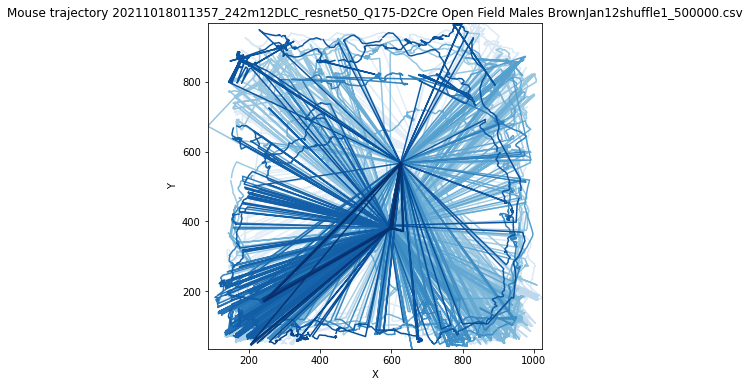

Rendering the following labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]!


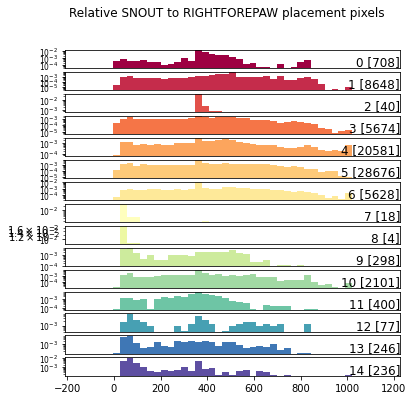

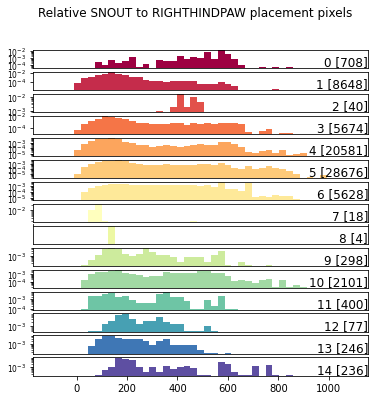

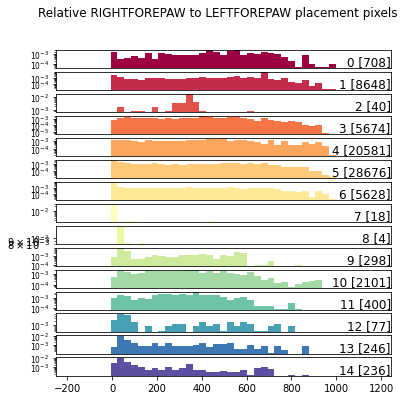

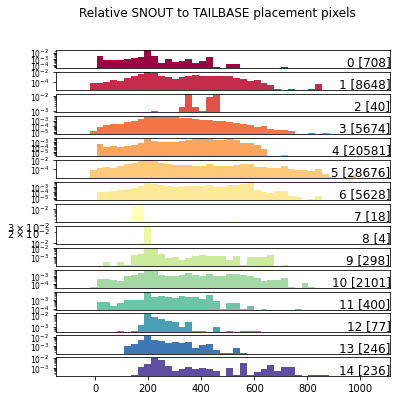

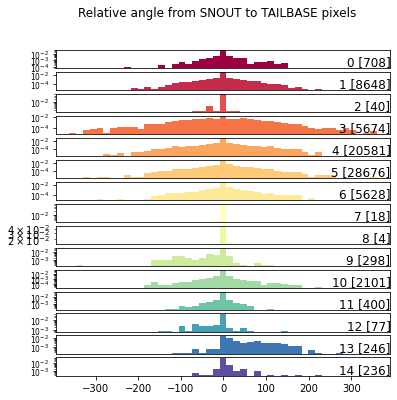

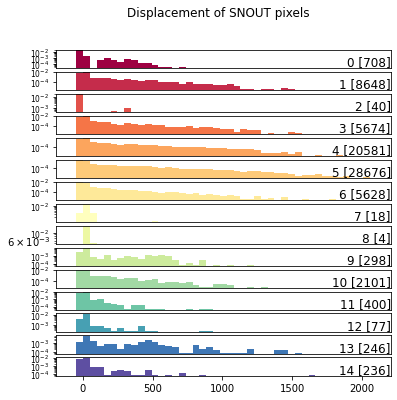

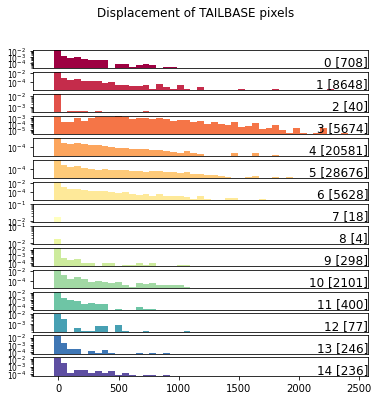

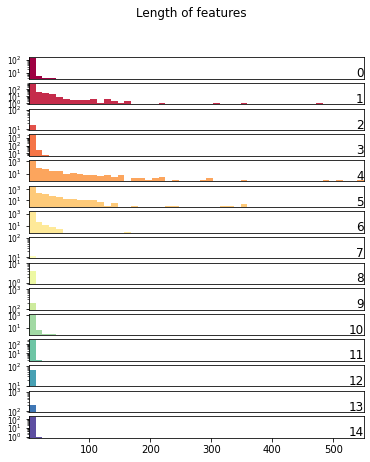

Extracting pregenerated labels and computing features!
Failed fetching a precompute set of feature from D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\features_and_labels\Akira_Feb262024_network; computing.
Saving results to: D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\features_and_labels\Akira_Feb262024_network
End.


100%|████████████████████████████████████████████████████████████████████| 7/7 [00:11<00:00,  1.59s/it]


Saving Mouse trajectory 20220228203032_316367_m2_openfieldDLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv to D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\figures\Akira_Feb262024_network\mouseTrajectory!


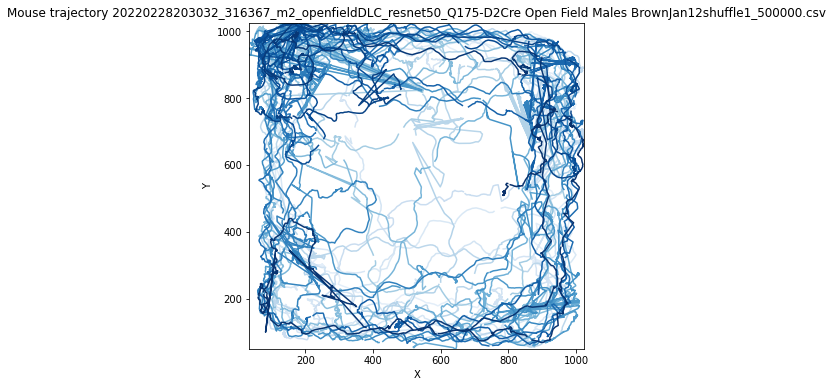

Rendering the following labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]!


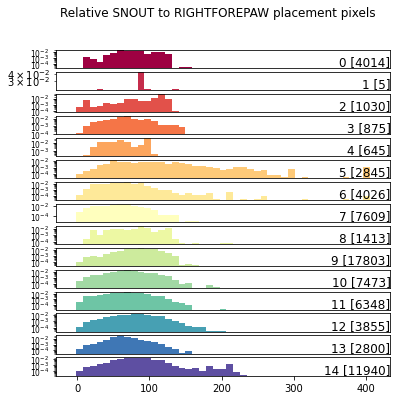

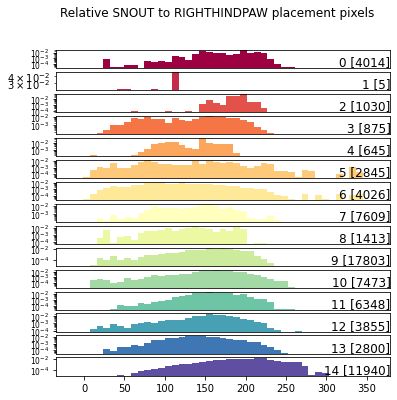

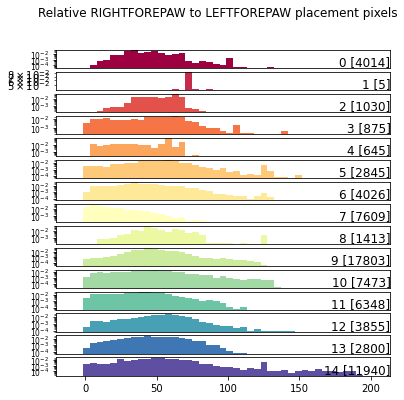

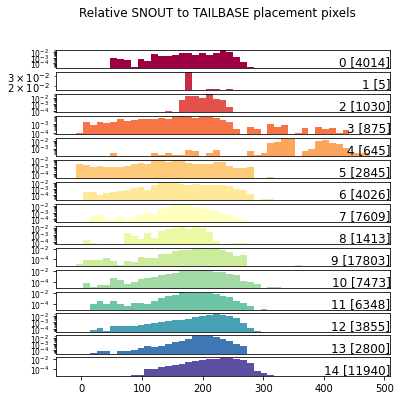

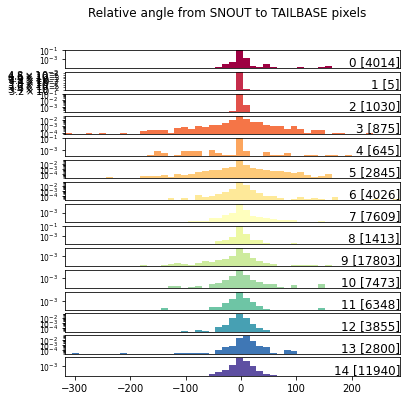

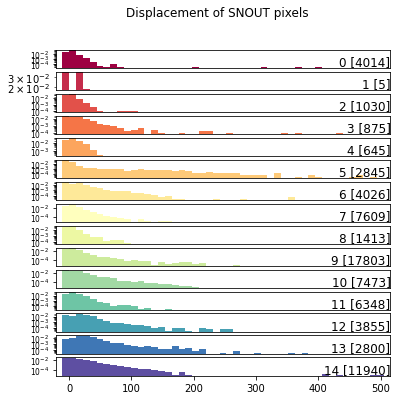

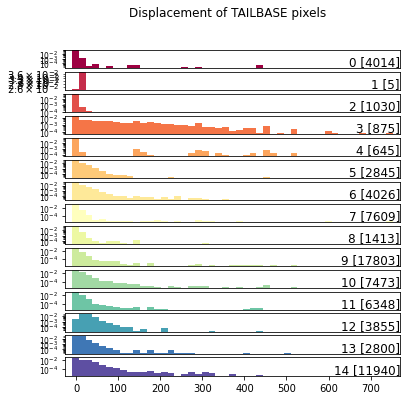

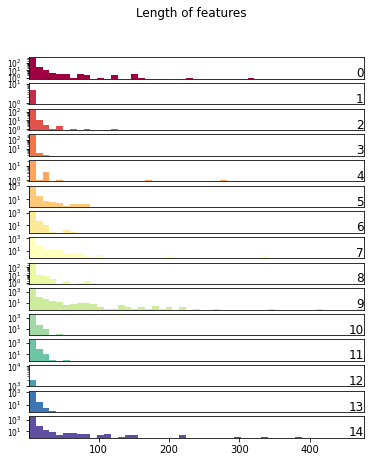

Extracting pregenerated labels and computing features!
Failed fetching a precompute set of feature from D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\features_and_labels\Akira_Feb262024_network; computing.
Saving results to: D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\features_and_labels\Akira_Feb262024_network
End.


100%|████████████████████████████████████████████████████████████████████| 7/7 [00:12<00:00,  1.79s/it]


Saving Mouse trajectory 20220228223808_320151_m1_openfieldDLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv to D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\figures\Akira_Feb262024_network\mouseTrajectory!


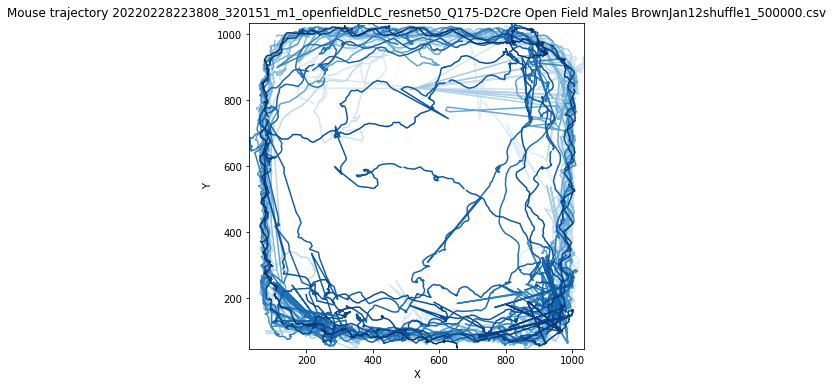

Rendering the following labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]!


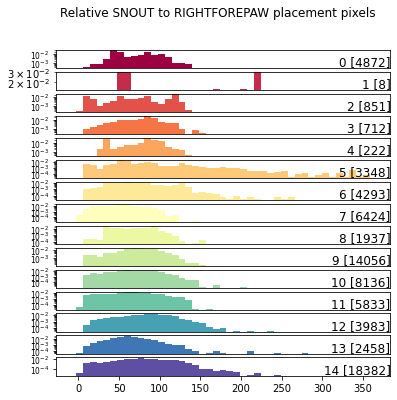

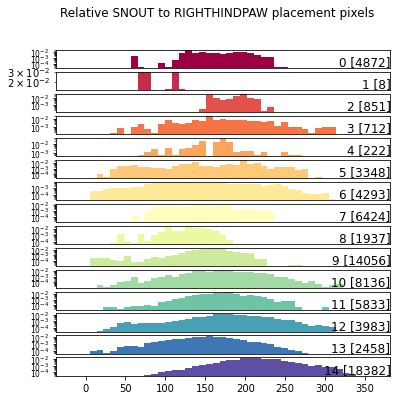

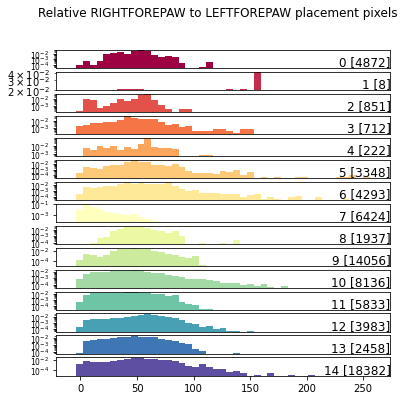

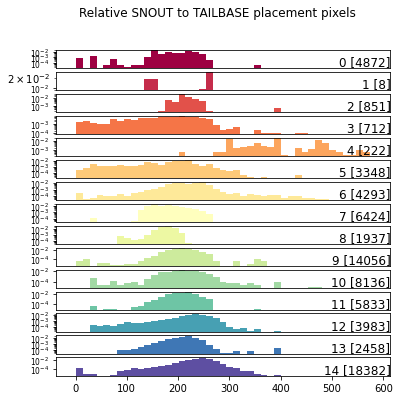

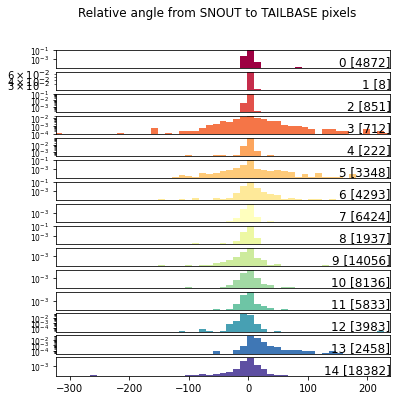

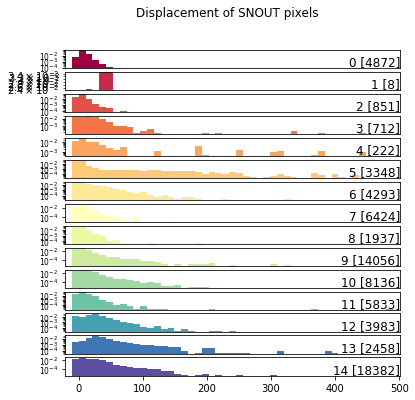

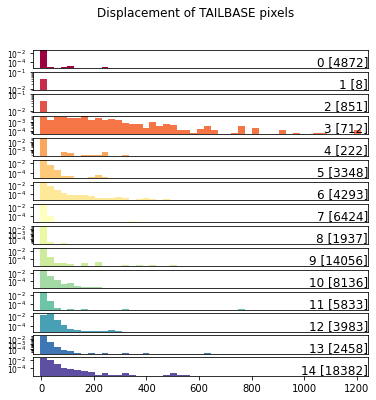

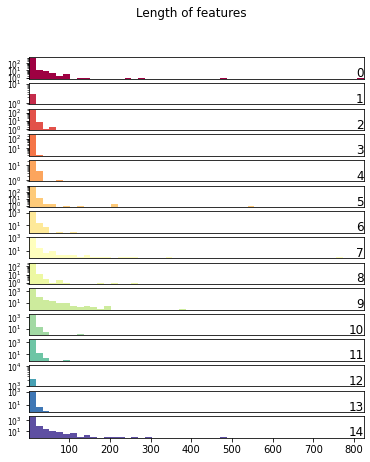

Extracting pregenerated labels and computing features!
Failed fetching a precompute set of feature from D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\features_and_labels\Akira_Feb262024_network; computing.
Saving results to: D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\features_and_labels\Akira_Feb262024_network
End.


100%|████████████████████████████████████████████████████████████████████| 7/7 [00:12<00:00,  1.81s/it]


Saving Mouse trajectory 20220228231804_320151_m2_openfieldDLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv to D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\figures\Akira_Feb262024_network\mouseTrajectory!


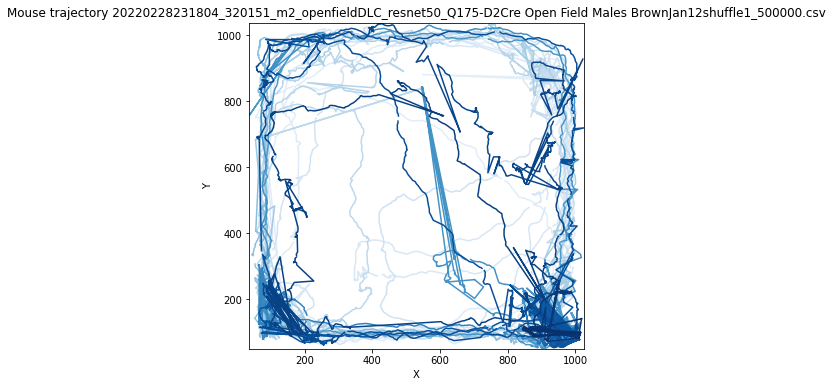

Rendering the following labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]!


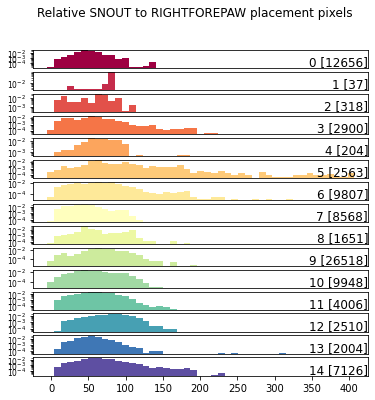

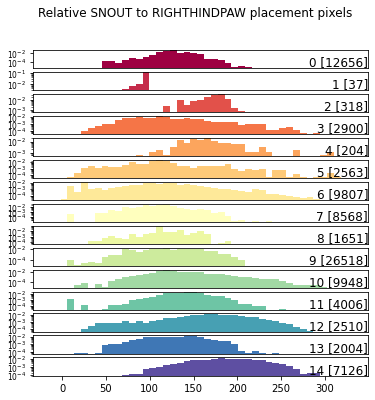

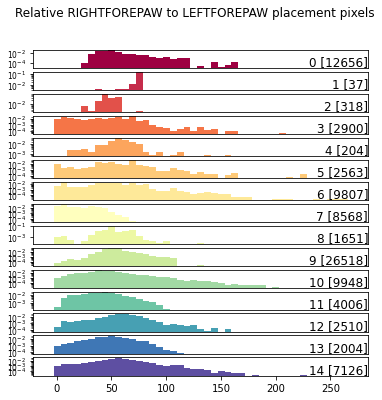

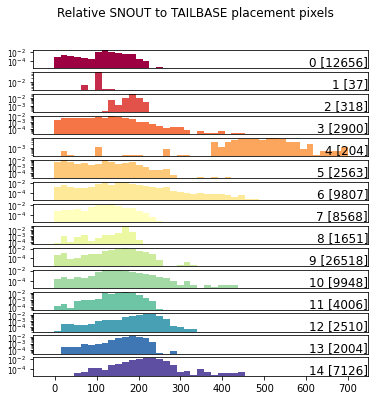

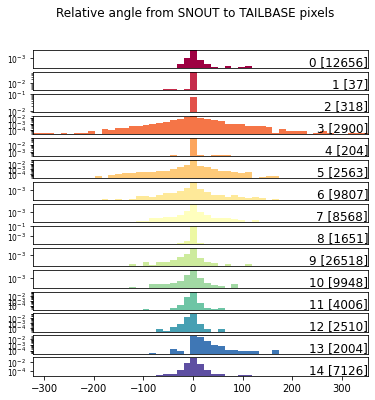

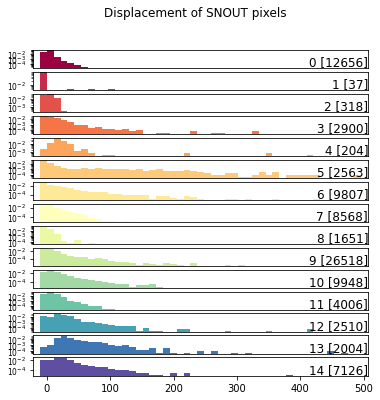

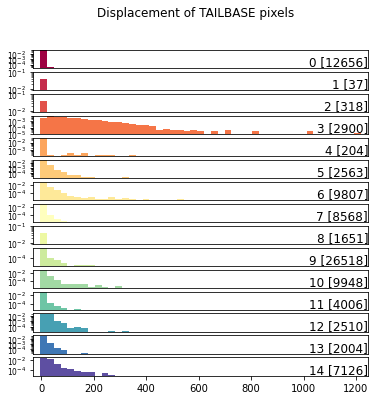

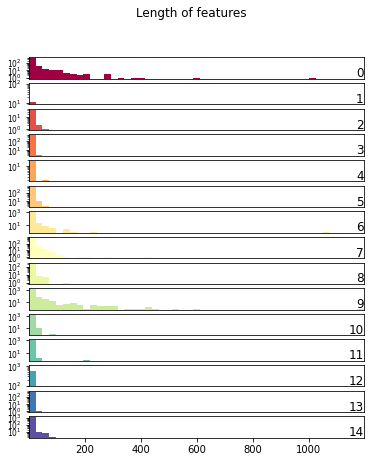

Extracting pregenerated labels and computing features!
Failed fetching a precompute set of feature from D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\features_and_labels\Akira_Feb262024_network; computing.
Saving results to: D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\features_and_labels\Akira_Feb262024_network
End.


100%|████████████████████████████████████████████████████████████████████| 7/7 [00:07<00:00,  1.13s/it]


Saving Mouse trajectory 20220228235946_320151_m3_openfieldDLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv to D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\figures\Akira_Feb262024_network\mouseTrajectory!


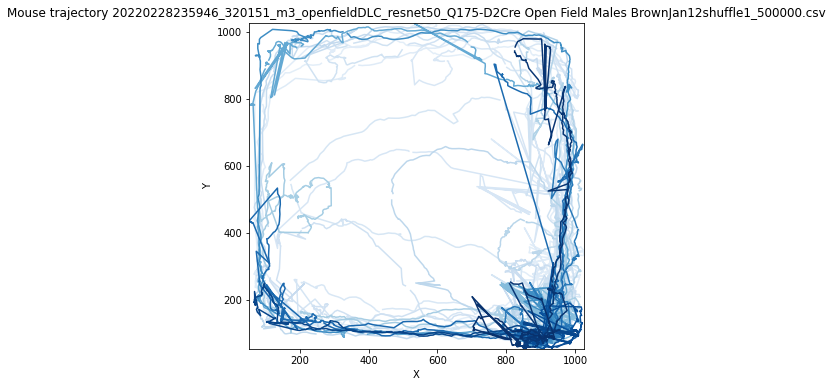

Rendering the following labels: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]!


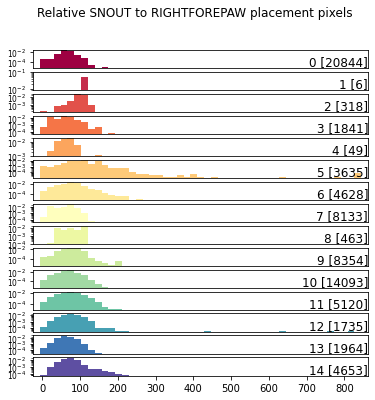

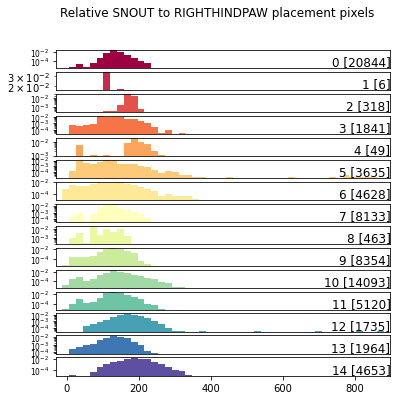

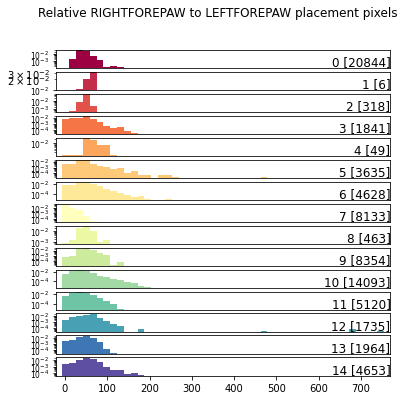

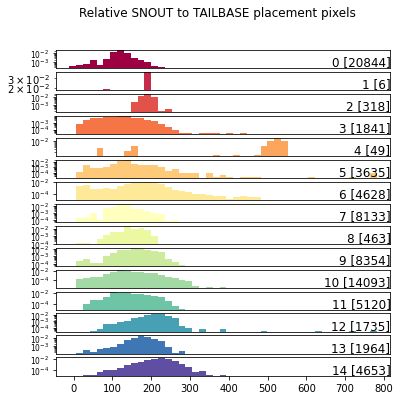

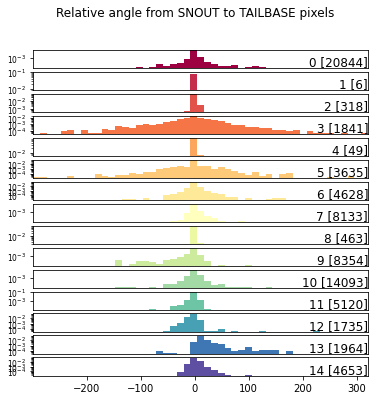

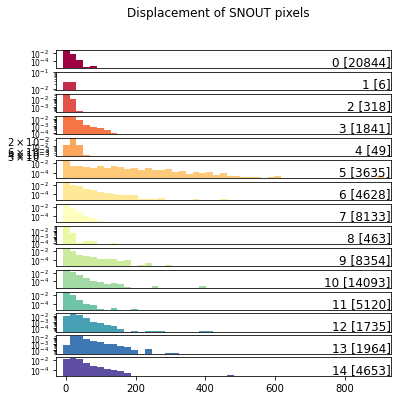

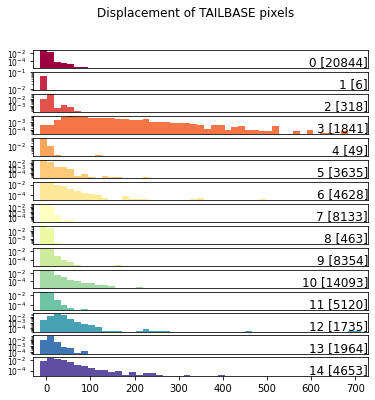

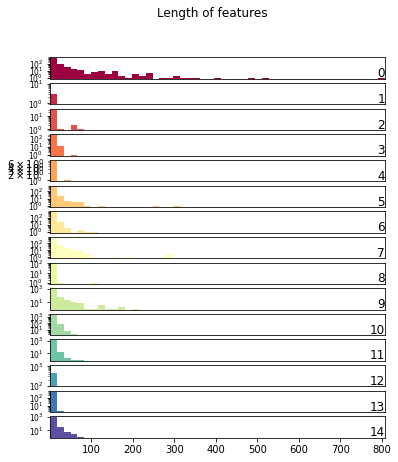

Extracting pregenerated labels and computing features!
Failed fetching a precompute set of feature from D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\features_and_labels\Akira_Feb262024_network; computing.
Saving results to: D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\features_and_labels\Akira_Feb262024_network
End.


100%|████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.28s/it]


Saving Mouse trajectory 20230107131118_363453_m1_openfieldDLC_resnet50_Q175-D2Cre Open Field Males BrownJan12shuffle1_500000.csv to D:\B-SOID\Akira\feature_visualization_JupyterNotebook\results\figures\Akira_Feb262024_network\mouseTrajectory!


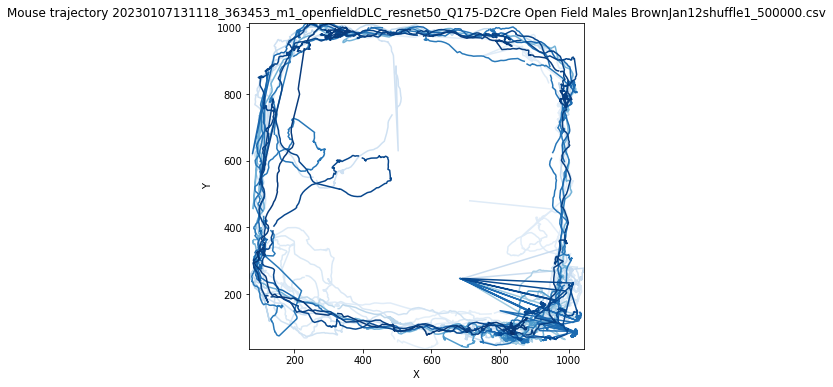

Rendering the following labels: [0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]!


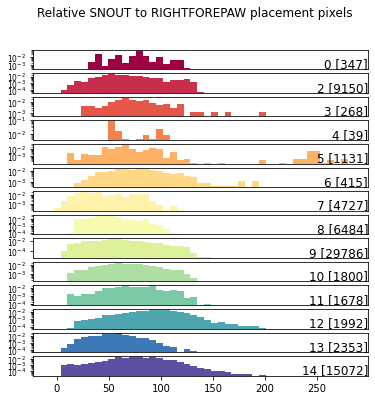

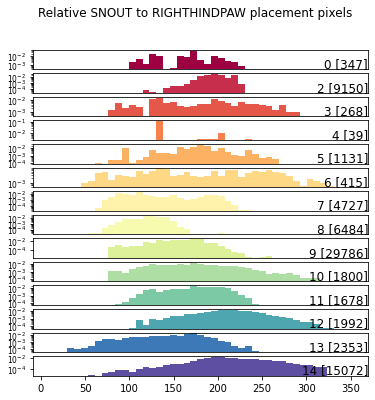

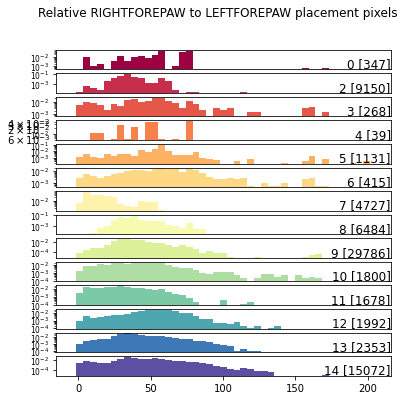

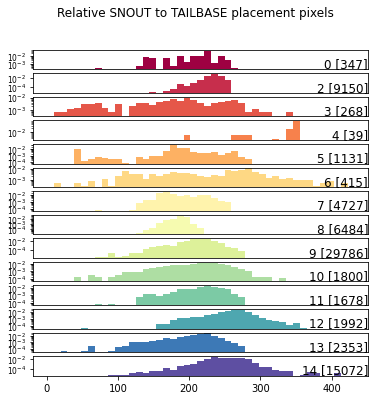

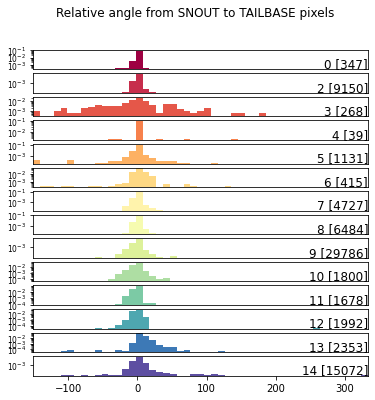

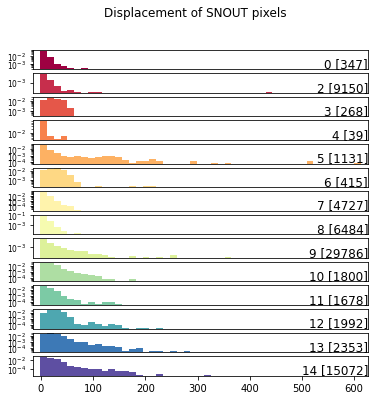

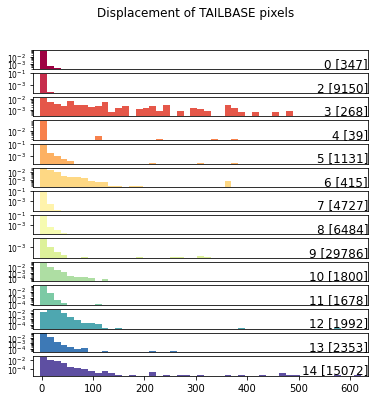

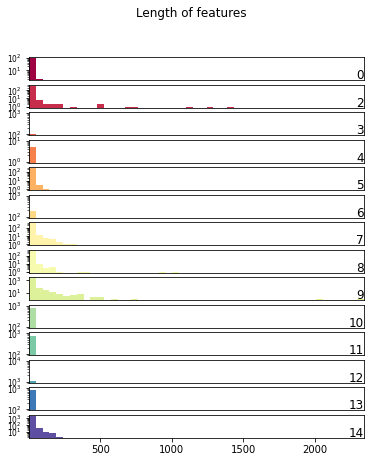

In [ ]:
for csvfile in CSVFILE_OF_INTEREST:
  main(csvfile)